In [2]:
'''
Code Outline:
1. Autoencoder
2. Demo of Autoencoder
3. Evaluation of Autoencoder
4. tSNE
'''

'\nCode Outline:\n1. Autoencoder\n2. Demo of Autoencoder\n3. Evaluation of Autoencoder\n4. tSNE\n'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [4]:
(X, Y), (X_test, Y_test) = mnist.load_data()

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, random_state=314159, test_size=0.2, shuffle=True, stratify=Y)

# Normalize pixel values to the range [0, 1] for autoencoder
en_X_train = X_train.astype('float32') / 255
en_X_val = X_val.astype('float32') / 255
en_X_test = X_test.astype('float32') / 255

# can remove the one_hot_encoding and use sparse_categorical_cross_entropy (as Raschka does), performace similar

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
Y_val = to_categorical(Y_val)

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
from tensorflow.keras import regularizers

class DenoisingAutoencoder(Model):
    def __init__(self, latent_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            # layers.GaussianNoise(0.1),  # Add Gaussian noise to input
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),  # Dropout for regularization
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])
        # NOTE: the sigmoid activation is for each pixel

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

latent_dim = 32
# Instantiate the denoising autoencoder model
autoencoder = DenoisingAutoencoder(latent_dim)

# Compile the model with appropriate optimizer and loss function
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Note about Model Architecture: I initially considered adding Gaussian noise based on a video I watched about autoencoders but found that was not a good idea.
Regarding the choice of 32 for latent dimensions, since this is a relatively simple task, I felt that 64 was overkill (and once I saw the evaluation results, I stuck with this decision).
Otherwise, the architecture is pretty much a mirror image: 2 convultional layers to encode and Convultional Transpose layers to decode.

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
'''
Including early stopping so I can set a high epoch number and rely on stopping to prevent overfitting.
'''

# Train the model with noisy inputs and clean outputs
history = autoencoder.fit(en_X_train, en_X_train,
                                    epochs=10,
                                    shuffle=True,
                                    validation_data=(en_X_val, en_X_val), callbacks=[early_stopping])

Epoch 1/10
1500/1500 [==============================] - 32s 20ms/step - loss: 0.0170 - val_loss: 0.0023
Epoch 2/10
1500/1500 [==============================] - 32s 22ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 3/10
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 4/10
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 5/10
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 6/10
1500/1500 [==============================] - 30s 20ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 7/10
1500/1500 [==============================] - 30s 20ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 8/10
1500/1500 [==============================] - 31s 20ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 9/10
1500/1500 [==============================] - 30s 20ms/step - loss: 0.0020 - val_loss: 9.7114e-04
Epoch 10/10
1500/1500 [==============================] - 30s

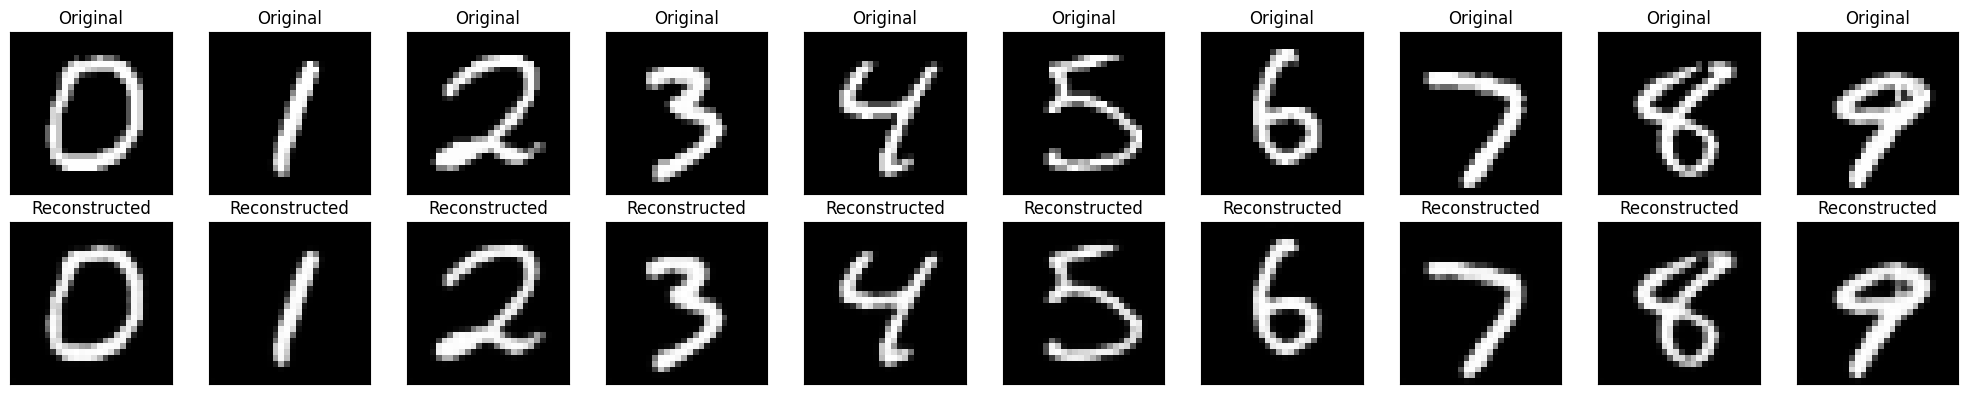

In [7]:
# Encode and decode images from the test set
encoded_imgs = autoencoder.encoder(en_X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# Display original and reconstructed images for one example of each digit
plt.figure(figsize=(20, 4))

for digit in range(10):
    # Find indices of examples corresponding to the current digit
    digit_indices = np.where(np.argmax(Y_test, axis=1) == digit)[0]
    if len(digit_indices) == 0:
        print(f"No examples of digit {digit} in the test set.")
        continue

    # Select the second image corresponding to the current digit (the first 5 looks really bad)
    digit_index = digit_indices[1]

    # Display original
    ax = plt.subplot(2, 10, digit + 1)
    plt.imshow(X_test[digit_index].reshape(28, 28))
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 10, digit + 11)
    plt.imshow(decoded_imgs[digit_index].reshape(28, 28))
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [8]:
print(decoded_imgs.shape)
print(decoded_imgs[0].shape)

(10000, 28, 28, 1)
(28, 28, 1)


In [9]:
'''
I thought an interesting way to evaluate the strength of the model was to try to classify the images using the neural network we used
to classify the images in the first place.

Below, I copied the same CNN code from last week and train it on the CNN code. I then treat my encoded_images as a new test set
'''

'\nI thought an interesting way to evaluate the strength of the model was to try to classify the images using the neural network we used\nto classify the images in the first place.\n\nBelow, I copied the same CNN code from last week and train it on the CNN code. I then treat my encoded_images as a new test set\n'

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Define a simple CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
'''
Including early stopping so I can set a high epoch number and rely on stopping to prevent overfitting.
'''

# Train the model with the adjusted batch size
# Train the CNN model
cnn_history = cnn_model.fit(en_X_train, Y_train, epochs=20, batch_size=64, validation_data=(en_X_val, Y_val), shuffle=True, callbacks=[early_stopping])

Epoch 1/20
750/750 [==============================] - 24s 31ms/step - loss: 0.2134 - accuracy: 0.9351 - val_loss: 0.0677 - val_accuracy: 0.9791
Epoch 2/20
750/750 [==============================] - 23s 30ms/step - loss: 0.0605 - accuracy: 0.9813 - val_loss: 0.0475 - val_accuracy: 0.9842
Epoch 3/20
750/750 [==============================] - 23s 30ms/step - loss: 0.0420 - accuracy: 0.9873 - val_loss: 0.0420 - val_accuracy: 0.9887
Epoch 4/20
750/750 [==============================] - 23s 30ms/step - loss: 0.0333 - accuracy: 0.9897 - val_loss: 0.0510 - val_accuracy: 0.9843
Epoch 5/20
750/750 [==============================] - 23s 31ms/step - loss: 0.0262 - accuracy: 0.9918 - val_loss: 0.0338 - val_accuracy: 0.9903
Epoch 6/20
750/750 [==============================] - 23s 30ms/step - loss: 0.0207 - accuracy: 0.9935 - val_loss: 0.0386 - val_accuracy: 0.9898
Epoch 7/20
750/750 [==============================] - 24s 32ms/step - loss: 0.0183 - accuracy: 0.9937 - val_loss: 0.0426 - val_accuracy:

In [12]:
print(en_X_test.shape)
print(en_X_test[0].shape)

(10000, 28, 28)
(28, 28)


In [13]:
# First get our stats for CNN
cnn_predictions = cnn_model.predict(en_X_test)
cnn_predicted_labels = np.argmax(cnn_predictions, axis=1)
cnn_true_labels = np.argmax(Y_test, axis=1)

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Classification Report
print("Classification Report:")
print(classification_report(cnn_true_labels, cnn_predicted_labels))

# Accuracy
cnn_accuracy = accuracy_score(cnn_true_labels, cnn_predicted_labels)
print("Accuracy:", cnn_accuracy)

# Precision
cnn_precision = precision_score(cnn_true_labels, cnn_predicted_labels, average='weighted')  # Use 'weighted' for multiclass classification
print("Precision:", cnn_precision)

# Recall
cnn_recall = recall_score(cnn_true_labels, cnn_predicted_labels, average='weighted')  # Use 'weighted' for multiclass classification
print("Recall:", cnn_recall)

# F1 Score
cnn_f1 = f1_score(cnn_true_labels, cnn_predicted_labels, average='weighted')  # Use 'weighted' for multiclass classification
print("F1 Score:", cnn_f1)

# Confusion Matrix
conf_matrix = confusion_matrix(cnn_true_labels, cnn_predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

313/313 [==============================] - 2s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Accuracy: 0.9918
Precision: 0.991825836485584
Recall: 0.9918
F1 Score: 0.9917959995779007
Confusion Matrix:
[[ 974    0    0    1    0    1    2    2    0    0]
 [

In [14]:
# Test our decoded images against the CNN
decoded_imgs = decoded_imgs.astype('float32')

en_predictions = cnn_model.predict(decoded_imgs)
en_predicted_labels = np.argmax(en_predictions, axis=1)  # Predicted labels for decoded images

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Classification Report
print("Classification Report:")
print(classification_report(cnn_true_labels, en_predicted_labels))  # Use true labels from the original dataset

# Accuracy
en_accuracy = accuracy_score(cnn_true_labels, en_predicted_labels)
print("Accuracy:", en_accuracy)

# Precision
en_precision = precision_score(cnn_true_labels, en_predicted_labels, average='weighted')  # Use 'weighted' for multiclass classification
print("Precision:", en_precision)

# Recall
en_recall = recall_score(cnn_true_labels, en_predicted_labels, average='weighted')  # Use 'weighted' for multiclass classification
print("Recall:", en_recall)

# F1 Score
en_f1 = f1_score(cnn_true_labels, en_predicted_labels, average='weighted')  # Use 'weighted' for multiclass classification
print("F1 Score:", en_f1)

# Confusion Matrix
conf_matrix = confusion_matrix(cnn_true_labels, en_predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

313/313 [==============================] - 2s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Accuracy: 0.9911
Precision: 0.9911431841397258
Recall: 0.9911
F1 Score: 0.9910958811558462
Confusion Matrix:
[[ 976    0    0    1    0    1    1    1    0    0]
 

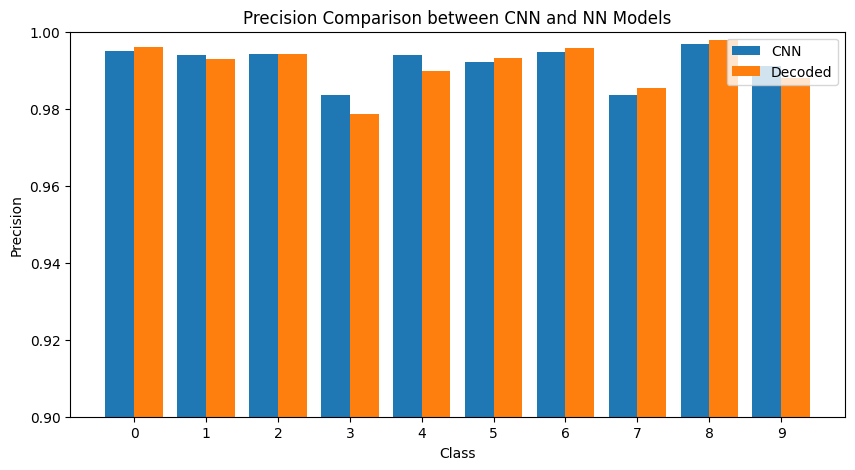

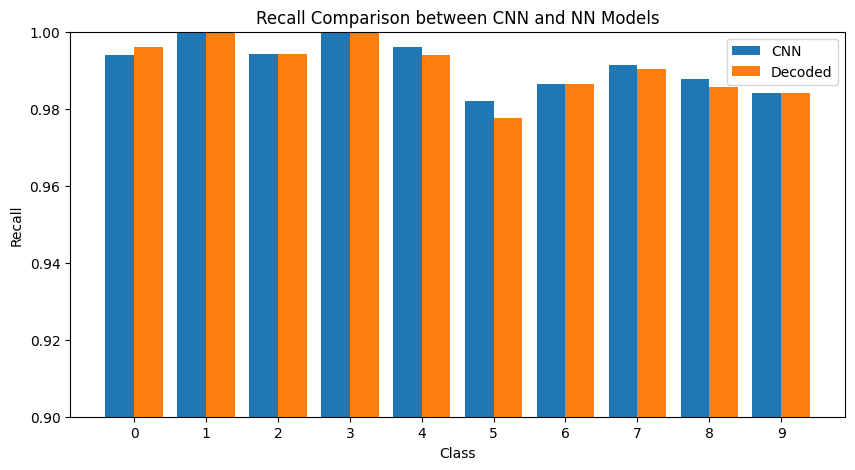

In [15]:
# compare precision and recall of the two models
from sklearn.metrics import precision_score, recall_score

# # # Calculate precision for CNN and NN models
cnn_precision = precision_score(cnn_true_labels, cnn_predicted_labels, average=None)
nn_precision = precision_score(cnn_true_labels, en_predicted_labels, average=None)

# # Calculate recall for CNN and NN models
cnn_recall = recall_score(cnn_true_labels, cnn_predicted_labels, average=None)
nn_recall = recall_score(cnn_true_labels, en_predicted_labels, average=None)

# Plot precision for both models
plt.figure(figsize=(10, 5))
plt.bar(np.arange(10) - 0.2, cnn_precision, width=0.4, label='CNN')
plt.bar(np.arange(10) + 0.2, nn_precision, width=0.4, label='Decoded')
plt.xticks(np.arange(10), np.arange(10))
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision Comparison between CNN and NN Models')
plt.legend()
plt.ylim(0.9, 1)
plt.show()

# Plot recall for both models
plt.figure(figsize=(10, 5))
plt.bar(np.arange(10) - 0.2, cnn_recall, width=0.4, label='CNN')
plt.bar(np.arange(10) + 0.2, nn_recall, width=0.4, label='Decoded')
plt.xticks(np.arange(10), np.arange(10))
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall Comparison between CNN and NN Models')
plt.legend()
plt.ylim(0.9, 1)
plt.show()

In [16]:
# Create a list to store indices of images with different predictions
different_predictions_indices = []

# Iterate through each index and compare predictions
for i in range(len(cnn_predicted_labels)):
    if cnn_predicted_labels[i] != en_predicted_labels[i]:
        different_predictions_indices.append(i)

# Print the indices of images with different predictions
print("Indices of images with different predictions from original to decoded:", different_predictions_indices)
print("Amount of differences: ",len(different_predictions_indices))
print("Percentage different: ", len(different_predictions_indices)/len(cnn_predicted_labels))

Indices of images with different predictions from original to decoded: [92, 115, 659, 740, 882, 1414, 1530, 2093, 2810, 2939, 3289, 3333, 3818, 3968, 4360, 4405, 4761, 4860, 4956, 6028, 6532, 9638, 9669]
Amount of differences:  23
Percentage different:  0.0023


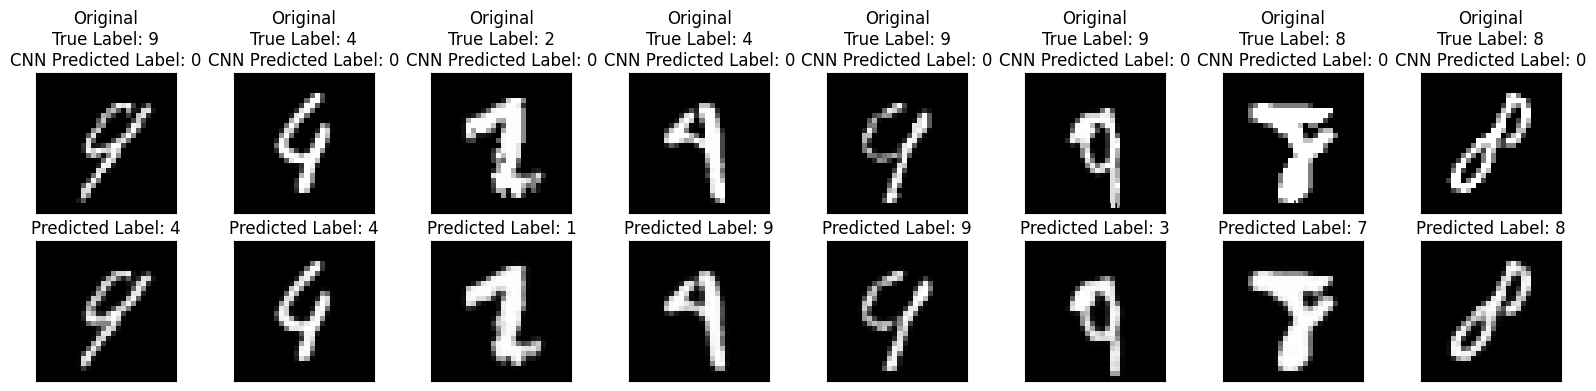

In [17]:
# plot the images with different labels

# Display original and reconstructed images
n = 8
plt.figure(figsize=(20, 4))
i = 0
for label in different_predictions_indices:
    if i >= n:
        break
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[label].reshape(28, 28))
    true_label = np.argmax(Y_test[label])
    cnn_predicted_label_original = np.argmax(cnn_predicted_labels[label])
    plt.title(f"Original\nTrue Label: {true_label}\nCNN Predicted Label: {cnn_predicted_label_original}")  # Add true label and CNN predicted label to title
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[label].reshape(28, 28))
    plt.title(f"Reconstructed\nPredicted Label: {en_predicted_labels[label]}")  # Add predicted label to title
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()


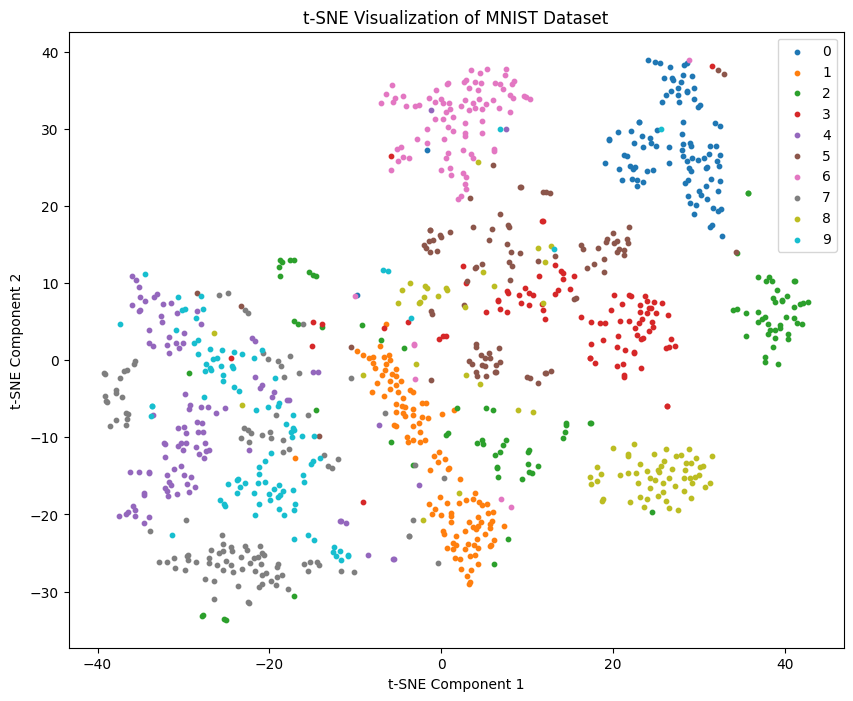

In [18]:
from sklearn.manifold import TSNE

# Reshape the data for t-SNE
X_reshaped = X.reshape(X.shape[0], -1)[:1000]  # Use a subset of the dataset for faster visualization
Y_subset = Y[:1000]

# Apply t-SNE to reduce the dimensionality of the data
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_reshaped)

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
for i in range(10):  # Plot each digit class separately
    plt.scatter(X_tsne[Y_subset == i, 0], X_tsne[Y_subset == i, 1], label=str(i), s=10)
plt.title('t-SNE Visualization of MNIST Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

1. I tried to mess around with the n-components variable and found out that "'n_components' should be inferior to 4 for the barnes_hut algorithm as it relies on quad-tree or oct-tree." I do not know what this means.
2. "The goal is to take a set of points in a high-dimensional space and find a faithful representation of those points in a lower-dimensional space, typically the 2D plane" (https://distill.pub/2016/misread-tsne/) - As such I kept it to 2 components.

